In [1]:
import os
import bayes3d as b
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from transformers import AutoModel
import os
import bayes3d as b


GenJAX not installed. Importing bayes3d without genjax dependencies.


In [11]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('49', '1', bop_ycb_dir)
frame_src = b.get_rgb_image(rgbd.rgb)

bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('51', '1', bop_ycb_dir)
frame_dst = b.get_rgb_image(rgbd.rgb)

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from transformers import AutoModel

In [5]:
def coords_grid(b, h, w, homogeneous=False, device=None):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w))  # [H, W]

    stacks = [x, y]

    if homogeneous:
        ones = torch.ones_like(x)  # [H, W]
        stacks.append(ones)

    grid = torch.stack(stacks, dim=0).float()  # [2, H, W] or [3, H, W]

    grid = grid[None].repeat(b, 1, 1, 1)  # [B, 2, H, W] or [B, 3, H, W]

    if device is not None:
        grid = grid.to(device)

    return grid

In [6]:
model = AutoModel.from_pretrained("stevetod/doduo", trust_remote_code=True)


In [13]:
frame1_img = np.array(frame_src)
frame2_img = np.array(frame_dst)

In [14]:
flow = model(frame_src, frame_dst)
flow_coords = coords_grid(flow.size(0), flow.size(2), flow.size(3)).to(flow.device)
matching = flow + flow_coords
matching = matching[0].long().cpu().numpy()

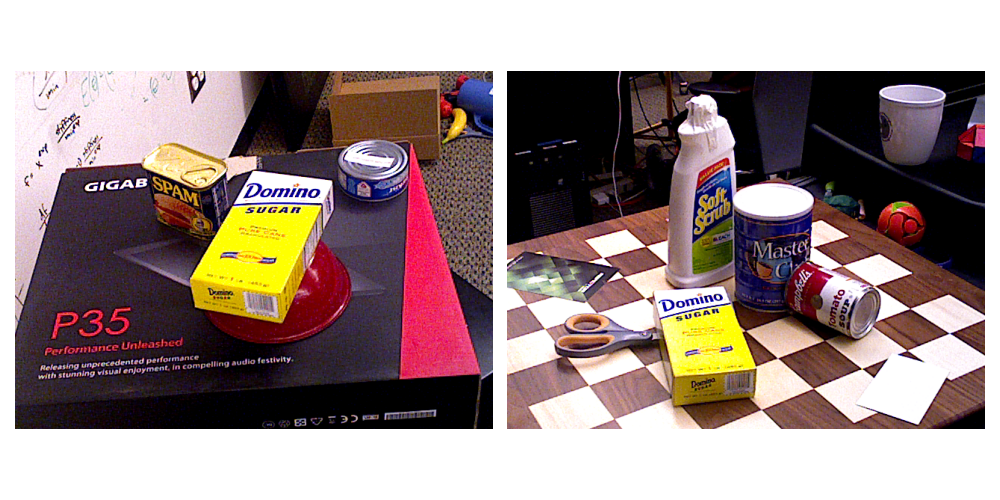

In [15]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(frame1_img)
axs[0].axis("off")
axs[1].imshow(frame2_img)
axs[1].axis("off")


def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        frame1_img_mark = cv2.circle(frame1_img.copy(), (x, y), 3, (0, 0, 255), -1)
        max_x, max_y = matching[:, y, x]
        frame2_img_mark = cv2.circle(frame2_img.copy(), (max_x, max_y), 3, (0, 255, 0), -1)
        axs[0].imshow(frame1_img_mark)
        axs[0].axis("off")
        axs[1].imshow(frame2_img_mark)
        axs[1].axis("off")
        plt.draw()


cid = fig.canvas.mpl_connect("button_press_event", onclick)
plt.tight_layout()
plt.show()